In [11]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
plt.rcParams['figure.figsize'] = 15, 10

# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
	torchvision.transforms.Normalize((0.5), (0.5))
])

# Downloading the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
	root="./MNIST/train", train=True,
	transform=torchvision.transforms.ToTensor(),
	download=True)

test_dataset = torchvision.datasets.MNIST(
	root="./MNIST/test", train=False,
	transform=torchvision.transforms.ToTensor(),
	download=True)



# Creating Dataloaders from the
# training and testing dataset
train_loader = torch.utils.data.DataLoader(
	train_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(
	test_dataset, batch_size=256)

# # Printing 25 random images from the training dataset
# random_samples = np.random.randint(
# 	1, len(train_dataset), (25))

# for idx in range(random_samples.shape[0]):
# 	plt.subplot(5, 5, idx + 1)
# 	plt.imshow(train_dataset[idx][0][0].numpy(), cmap='gray')
# 	plt.title(train_dataset[idx][1])
# 	plt.axis('off')

# plt.tight_layout()
# plt.show()



In [14]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
	def __init__(self):
		super().__init__()		
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(28 * 28, 256),
			torch.nn.ReLU(),
			torch.nn.Linear(256, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 64)
		)
		
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(64, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 256),
			torch.nn.ReLU(),
			torch.nn.Linear(256, 28 * 28),
			torch.nn.Sigmoid()
		)

	def encode(self, x):
		return self.encoder(x)

	def decode(self, x):
		return self.decoder(x)
	def forward(self, x):
		encoded = self.encode(x)
		decoded = self.decode(encoded)
		return decoded

# Instantiating the model and hyperparameters
model = DeepAutoencoder()
model = model.to('cuda')
criterion = torch.nn.MSELoss()
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [15]:
# List that will store the training loss
train_loss = []

# Dictionary that will store the
# different images and outputs for
# various epochs
outputs = {}

batch_size = len(train_loader)

b2 = []

for batch in train_loader:
			
		# Loading image(s) and
		# reshaping it into a 1-d vector
		img, _ = batch
		img = img.to('cuda')
		b2.append(img)
# Training loop starts
for epoch in range(num_epochs):
	
	# Initializing variable for storing
	# loss
	running_loss = 0
	
	# Iterating over the training dataset
	for batch in b2:
			
		# Loading image(s) and
		# reshaping it into a 1-d vector
		img = batch
		#img = img.to('cuda')
		img = img.reshape(-1, 28*28)
		
		# Generating output
		out = model(img)
		
		# Calculating loss
		loss = criterion(out, img)
		
		# Updating weights according
		# to the calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Incrementing loss
		running_loss += loss.item()
	
	# Averaging out loss over entire batch
	running_loss /= batch_size
	train_loss.append(running_loss)
	print(f"{running_loss} {epoch}")
	# Storing useful images and
	# reconstructed outputs for the last batch
	outputs[epoch+1] = {'img': img, 'out': out}





0.07563245004795967 0
0.052753721304396366 1
0.03731648829230603 2
0.030354808643460275 3
0.027357993330410186 4
0.025106369331479073 5
0.02337244730046455 6
0.021896307328914073 7
0.020717568568726804 8
0.019622760313622496 9
0.01874022123185878 10
0.01808200014874022 11
0.017293014896518372 12
0.01649074905175478 13
0.01584878654635333 14
0.015335308459210903 15
0.01487300206134294 16
0.014449692358996007 17
0.014039920401224431 18
0.013654797789739801 19
0.01328701155775405 20
0.012925651193933284 21
0.01257293273476844 22
0.012250716445293833 23
0.011980493136859954 24
0.01173812069712167 25
0.01147239606114144 26
0.011209095027694042 27
0.010961167557918011 28
0.010750899717528769 29
0.010580310641609608 30
0.010429882563333562 31
0.010300662955071064 32
0.010232863468217088 33
0.010142779128348574 34
0.010040184653344306 35
0.009910586464436764 36
0.00973381565368556 37
0.009578262796585864 38
0.009416818428546825 39
0.009261376105565974 40
0.009122114816799443 41
0.0090171098451

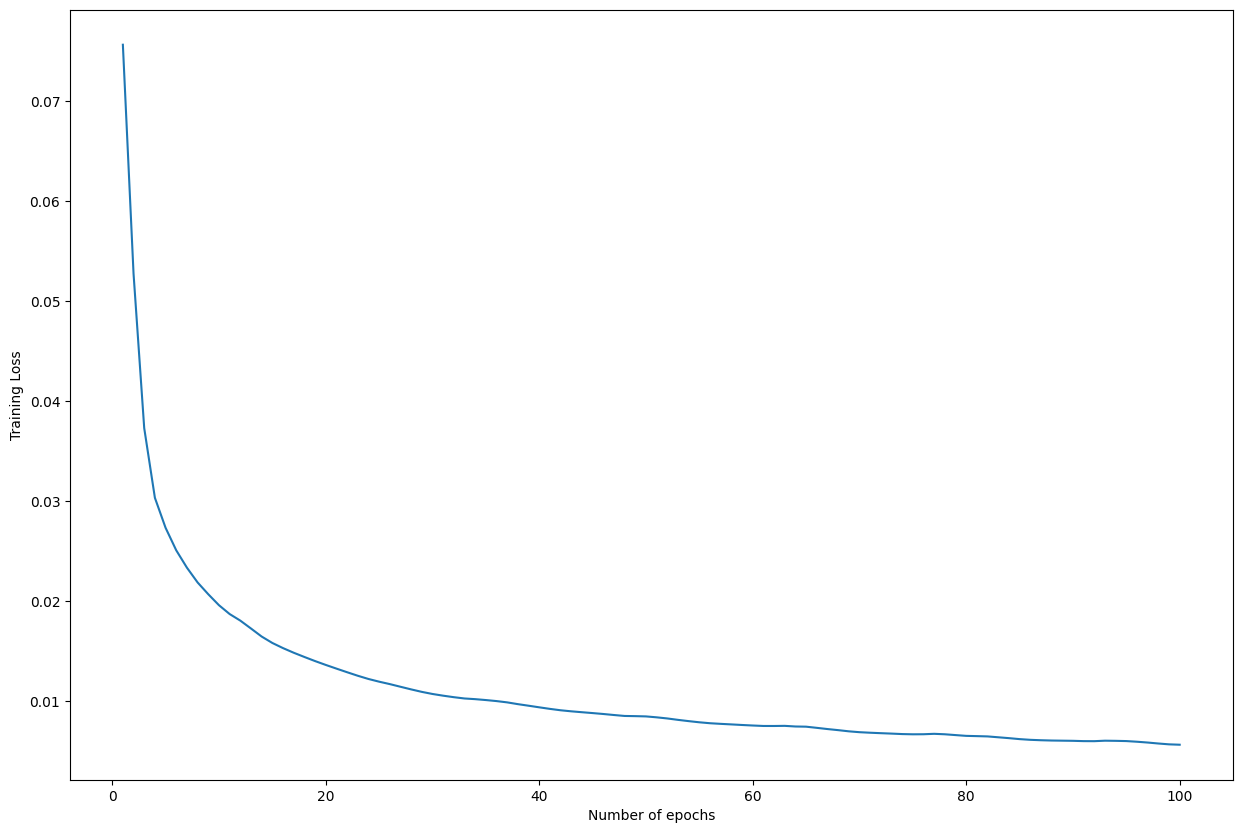

In [16]:
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

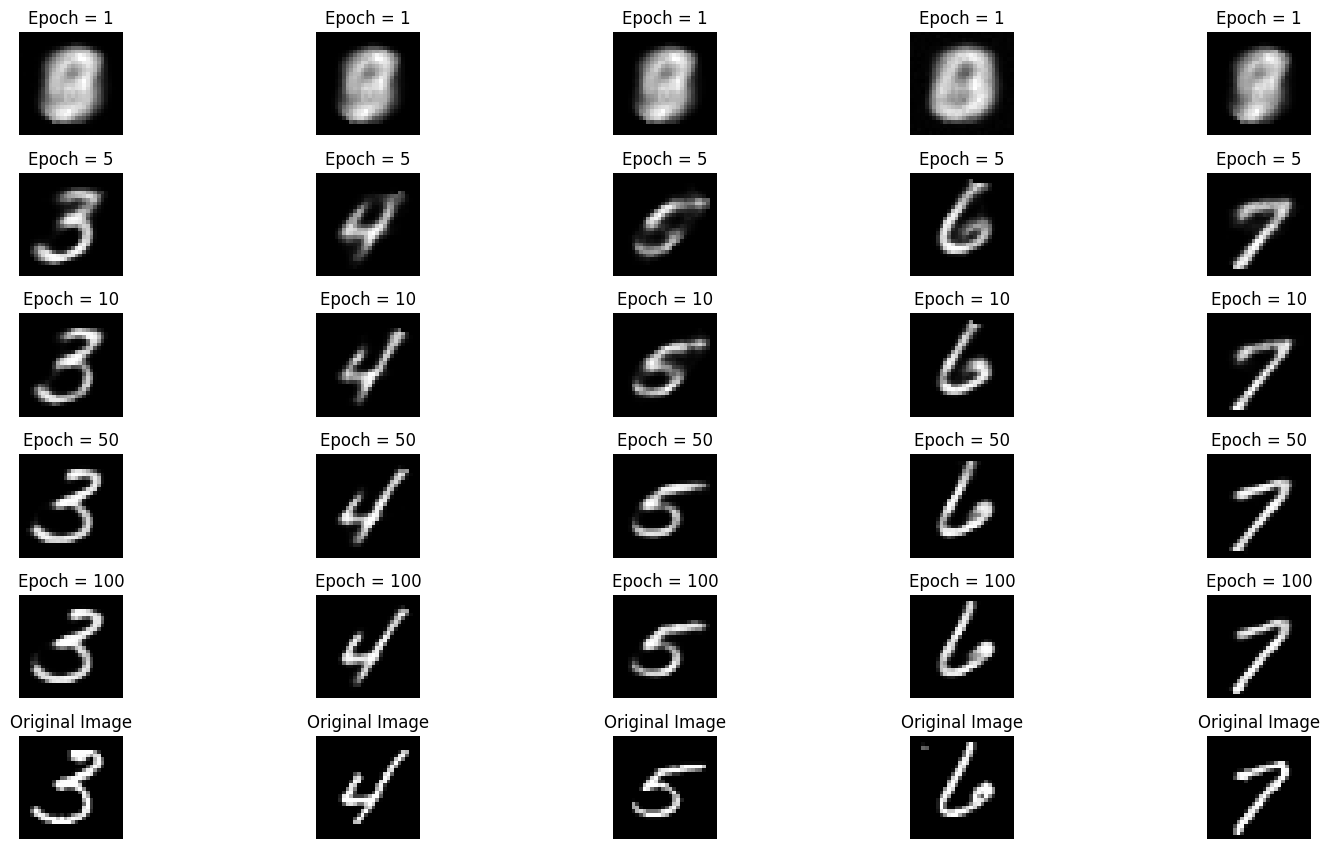

In [17]:
# Plotting is done on a 7x5 subplot
# Plotting the reconstructed images

# Initializing subplot counter
counter = 1

# Plotting reconstructions
# for epochs = [1, 5, 10, 50, 100]
epochs_list = [1, 5, 10, 50, 100]

# Iterating over specified epochs
for val in epochs_list:
	
	# Extracting recorded information
	temp = outputs[val]['out'].detach().cpu().numpy()
	title_text = f"Epoch = {val}"
	
	# Plotting first five images of the last batch
	for idx in range(5):
		plt.subplot(7, 5, counter)
		plt.title(title_text)
		plt.imshow(temp[idx].reshape(28,28), cmap= 'gray')
		plt.axis('off')
		
		# Incrementing the subplot counter
		counter+=1

# Plotting original images

# Iterating over first five
# images of the last batch
for idx in range(5):
	
	# Obtaining image from the dictionary
	val = outputs[10]['img'].cpu()
	
	# Plotting image
	plt.subplot(7,5,counter)
	plt.imshow(val[idx].reshape(28, 28),
			cmap = 'gray')
	plt.title("Original Image")
	plt.axis('off')
	
	# Incrementing subplot counter
	counter+=1

plt.tight_layout()
plt.show()


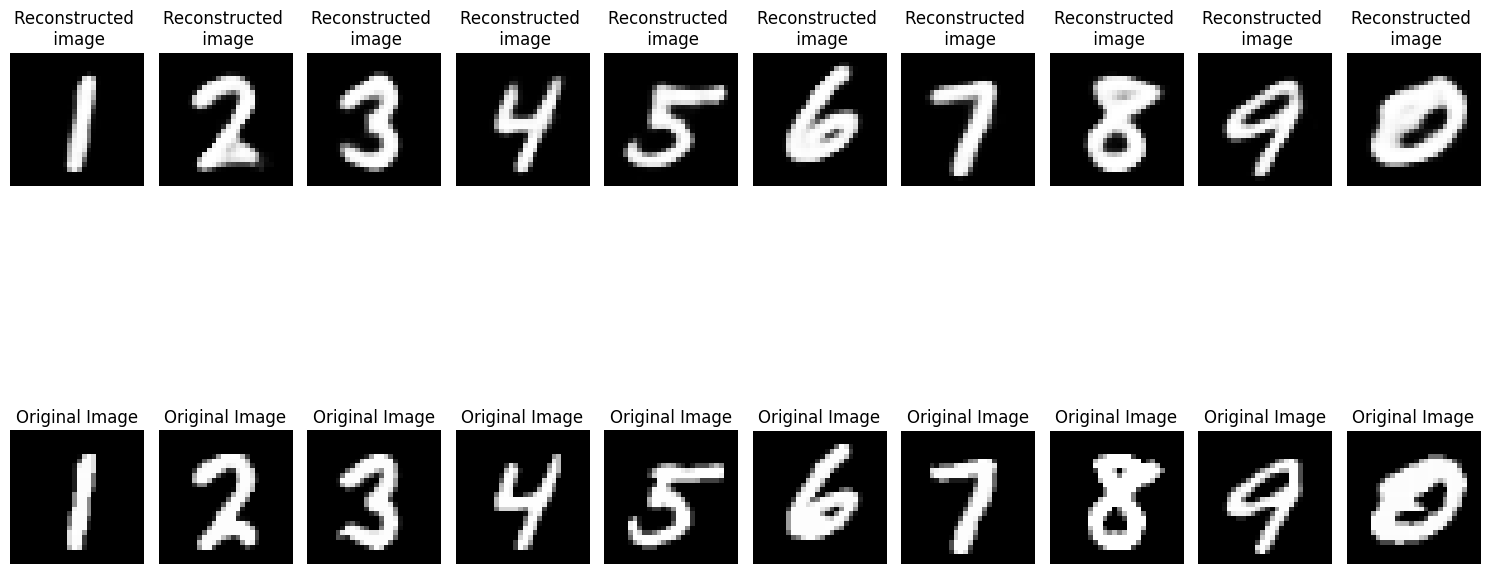

In [18]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}

# Extracting the last batch from the test
# dataset
img, _ = list(test_loader)[-1]

# Reshaping into 1d vector
img = img.reshape(-1, 28 * 28)
img = img.to('cuda')
# Generating output for the obtained
# batch

encoded = model.encode(img)

decoded = model.decode(encoded)

out = decoded

# Storing information in dictionary
outputs['img'] = img
outputs['out'] = decoded

# Plotting reconstructed images
# Initializing subplot counter
counter = 1
val = outputs['out'].detach().cpu().numpy()

# Plotting first 10 images of the batch
for idx in range(10):
	plt.subplot(2, 10, counter)
	plt.title("Reconstructed \n image")
	plt.imshow(val[idx].reshape(28, 28), cmap='gray')
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1

# Plotting original images

# Plotting first 10 images
for idx in range(10):
    val = outputs['img']
    plt.subplot(2, 10, counter)
    plt.imshow(val[idx].cpu().reshape(28, 28), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

	# Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()


In [20]:
torch.save(model.state_dict(), 'MNIST_Model.pth')

In [ ]:
model2 = DeepAutoencoder()
model2.load_state_dict(torch.load('MNIST_Model.pth'))
model2 = model.to('cuda')  # Don't forget to move the model to GPU if available